In [1]:
import numpy as np
import pandas as pd
import itertools
import collections
import math
import datetime
import bisect
import copy
import random
import time
import heapq
import scipy
from functools import reduce
from matplotlib import pyplot as plt
import os

In [2]:
# the functions compute the main indicators
from pandas import Series

def Percentage_Profit(X):
    '''
    Return investment strategy profit
    INPUT:
        X: series, strategy to evaluate
    OUTPUT:
        res: int, profit
    '''
    res = 100*((X[-1]/X[0])-1)
    return res

def Profit_Factor(X):
    '''
    Return investment strategy profit factor
    INPUT:
        X: series, strategy to evaluate
    OUTPUT:
        res: int, profit factor
    '''
    up = 0
    down = 0
    for t in range(1,len(X)):
        diff = X[t]-X[t-1]
        if diff > 0:
            up = up + diff
        else:
            down = down - diff
    res = up/down
    return res

def Percentage_Drawdown(X):
    '''
    Return investment strategy percentage drawdown
    INPUT:
        X: series, strategy to evaluate
    OUTPUT:
        res: int, percentage drawdown
    '''
    draw_p = 0
    draw = 0
    old_max = X[0]
    for t in range(1,len(X)):
        if X[t] > old_max:
            old_max = X[t]
        else:
            diff = old_max - X[t]
            if diff > draw:
                draw = diff
                draw_p = diff/old_max
    res = 100*draw_p
    return res

def Recovery_Factor(X):
    '''
    Return investment strategy recovery factor
    INPUT:
        X: series, strategy to evaluate
    OUTPUT:
        res: int, recovery factor
    '''
    total_profit = X[-1] - X[0]
    draw = 0
    old_max = X[0]
    for t in range(1,len(X)):
        if X[t] > old_max:
            old_max = X[t]
        else:
            diff = old_max - X[t]
            if diff > draw:
                draw = diff
    res = total_profit / draw
    return res

def Sharpe_Ratio(X):
    '''
    Return investment strategy sharpe ratio
    INPUT:
        X: series, strategy to evaluate
    OUTPUT:
        res: int, sharpe ratio
    '''
    from pandas import Series
    from numpy import sqrt, std
    
    X_rend = Series(X).pct_change()[1:]
    mu = ( X[-1]/X[0] )**(252/len(X)) - 1
    sigma = sqrt(252)*std(X_rend)
    res = mu / sigma
    return res

def Sortino_Ratio(X):
    '''
    Return investment strategy sortino ratio
    INPUT:
        X: series, strategy to evaluate
    OUTPUT:
        res: int, sortino ratio
    '''
    from numpy import sqrt
    from pandas import Series
    
    X_rend = Series(X).pct_change()[1:]
    downside_risk = X_rend[X_rend < X_rend.mean()].std()
    mu = ( X[-1]/X[0] )**(252/len(X)) - 1
    sigmaD = sqrt(252)*downside_risk
    res = mu / sigmaD
    return res


def Strategy_Evaluation(X, verbose=True, out=False, n_round=3):
    '''
    Evaluate investment strategy according to well-known metrics
    INPUT:
        X: series, strategy to evaluate
        verbose: bool, manages the verbosity. Default=True
        out: bool, if True, return metrics dict as output. Default=False
        n_round: int, number of decimals considered (if <=0, no round).Default=3
    OUTPUT:
        res: dict, metrics of the strategy
    '''
    from numpy import round
    Properties = {'Percentage Profit': Percentage_Profit(X),
            'Profit Factor': Profit_Factor(X),
            'Percentage Drawdown': Percentage_Drawdown(X),
            'Recovery Factor': Recovery_Factor(X),
            'Sharpe Ratio': Sharpe_Ratio(X),
            'Sortino Ratio': Sortino_Ratio(X)}
   
    
    return Properties

In [3]:
# read the orignal txt and transform it to stats
def read_file(file_path):
    vals = [] 
    dates = []
    d = []
    count = 0
    with open(file_path, 'r') as file:
        next(file) 
        for line in file:
            if line.strip() and line.strip()[0] == "2":
                date, value = line.strip().split(maxsplit=1)
                #data.append([date, float(value)])
                vals.append(float(value))
                dates.append(date)
            else:
                if len(vals)>0:
                    series = pd.Series(vals,index=dates)
                    t = Strategy_Evaluation(series, verbose=True, out=False, n_round=3)
                    d.append(t)
                
                    vals = [] 
                    dates = []
    if len(vals)>0:
        series = pd.Series(vals,index=dates)
        t = Strategy_Evaluation(series, verbose=True, out=False, n_round=3)
        d.append(t)
    df =  pd.DataFrame(d)
    stats_df = pd.DataFrame({
                'mean': df.mean(),
                'std': df.std(),
                'wse': df.min()
            }).transpose()
    return stats_df

In [4]:
# example
path = 'D:/github/ST5188_StatisticalProject/results/earning_filter'
files = os.listdir(path)
file = files[0] 
read_file(f'{path}/{file}').T

,mean,std,wse
Percentage Profit,0.089513,0.790689,-0.786499
Profit Factor,1.340749,1.225324,0.442572
Percentage Drawdown,0.671155,0.377702,0.152418
Recovery Factor,0.717684,2.278362,-0.777349
Sharpe Ratio,-0.097759,3.776331,-4.327433
Sortino Ratio,0.414416,9.537142,-14.314749


In [5]:
def add_file_index(df, file_name):
    df.index = pd.MultiIndex.from_product([[file_name], df.index], names=['Method', 'Perfermance'])
    return df

In [6]:
def highlight_metrics(row):
    styles = []
    
    # Initialize the variables to store max and min values for mean, std, and wse
    if row.name != "Percentage Drawdown":
        max_mean = row.xs('mean', level=1).max()
        min_std = row.xs('std', level=1).min()
        max_wse = row.xs('wse', level=1).max()

        # Iterate through each cell and apply styles based on the condition

        for method in row.index.get_level_values(0).unique():
            method_data = row[method]
            #mean_style = 'background-color: #add8e6' if method_data['mean'] == max_mean else ''
            #std_style = 'background-color: #ffcc99' if method_data['std'] == min_std else ''
            #wse_style = 'background-color: #98fb98' if method_data['wse'] == max_wse else ''
            mean_style = 'font-weight: bold' if method_data['mean'] == max_mean else ''
            std_style = 'font-weight: bold' if method_data['std'] == min_std else ''
            wse_style = 'font-weight: bold' if method_data['wse'] == max_wse else ''

            styles.extend([mean_style, std_style, wse_style])
    else:
        max_mean = row.xs('mean', level=1).min()
        min_std = row.xs('std', level=1).min()
        max_wse = row.xs('wse', level=1).min()

        # Iterate through each cell and apply styles based on the condition

        for method in row.index.get_level_values(0).unique():
            method_data = row[method]
            mean_style = ' font-weight: bold' if method_data['mean'] == max_mean else ''
            std_style = ' font-weight: bold' if method_data['std'] == min_std else ''
            wse_style = ' font-weight: bold' if method_data['wse'] == max_wse else ''

            styles.extend([mean_style, std_style, wse_style])
    return styles

In [7]:
# earining filter result
path = 'D:/github/ST5188_StatisticalProject/results/earning_filter'
files = os.listdir(path)
df = pd.concat({ f'earning_filter_{i/10}':add_file_index(read_file(f'{path}/{files[i]}'),'') for i in [1,5,10,18]}).T

new_columns = pd.MultiIndex.from_tuples([(x[0], x[2]) for x in df.columns])
df.columns = new_columns

df.style.apply(highlight_metrics,axis=1)

In [8]:
# guanularity test result 
file1 = 'D:/github/ST5188_StatisticalProject/results/benchmark/benchmark_100_port_test_monthly.txt'
file2 = 'D:/github/ST5188_StatisticalProject/results/quaterly/benchmark_100_port_test_quaterly.txt'

names = ["monthly","quaterly"]
files = [file1,file2]
df = pd.concat({names[i]:add_file_index(read_file(files[i]),'') for i in range(2)}).T
new_columns = pd.MultiIndex.from_tuples([(x[0], x[2]) for x in df.columns])
df.columns = new_columns
df.style.apply(highlight_metrics,axis=1)

In [9]:
# beachmark result
path = 'D:/github/ST5188_StatisticalProject/results/benchmark/'
files = os.listdir(path)
print(files)
names = ["benchmark","mean variance","min variance"]
pd.concat({names[i]:add_file_index(read_file(f'{path}/{files[i]}'),'') for i in range(3)}).T

['benchmark_100_port_test_monthly.txt', 'mean_100_test_model_and_statistics_last.txt', 'min_100_test_model_and_statistics_last.txt']


benchmark                      mean variance            \
Method                                                                       
Perfermance              mean       std        wse          mean       std   
Percentage Profit    0.031206  1.021714  -1.269941      0.029264  0.980020   
Profit Factor        1.037161  0.630244   0.319716      1.292471  0.800655   
Percentage Drawdown  1.166719  0.356855   0.737387      0.875562  0.646574   
Recovery Factor      0.149432  1.013720  -0.905379      0.668269  1.538338   
Sharpe Ratio        -0.530560  3.433618  -6.570996      0.632337  4.076986   
Sortino Ratio       -0.464355  5.793339 -11.190404      0.757438  7.161915   

                               min variance                       
Method                                                            
Perfermance                wse         mean       std        wse  
Percentage Profit    -2.050528     0.114490  1.282476  -1.987877  
Profit Factor         0.269779     1.675049  1.694441   0.241074  
Percentage Drawdown   0.253535     1.016497  0.725483   0.310831  
Recovery Factor      -1.000000     1.146407  2.140107  -1.000000  
Sharpe Ratio         -7.883708     0.939902  5.629972  -7.745485  
Sortino Ratio       -15.913693     1.119899  9.695222 -14.425367

In [10]:
# regression test stats
path = 'D:/github/ST5188_StatisticalProject/results/regression'
files = os.listdir(path)
print(files)
names = ["benchmark","ensemble","svr"]
df = pd.concat({names[i]:add_file_index(read_file(f'{path}/{files[i]}'),'') for i in range(3)}).T
new_columns = pd.MultiIndex.from_tuples([(x[0], x[2]) for x in df.columns])
df.columns = new_columns


styled_df = df.style.apply(highlight_metrics,axis=1)
styled_df

['benchmark_100_port_test_monthly.txt', 'Ensemble_statistics.txt', 'SVR_statistics.txt']


In [12]:
import pandas as pd
# Set display options
pd.set_option('display.max_rows', None)  # or use a large number if None is too much
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [13]:
# ablation study result
path = 'D:/github/ST5188_StatisticalProject/results/ablation_study_on_benchmark/'
files = os.listdir(path)
print(files)
names = ["best exclude earning_filter","best exclude granularity","best exclude regression",'best exclude nnpca','best']
df = pd.concat({names[i]:add_file_index(read_file(f'{path}/{files[i]}'),'') for i in range(len(names))}).T
#df.to_csv("D:/github/ST5188_StatisticalProject/results/table/ablation_result.csv")
new_columns = pd.MultiIndex.from_tuples([(x[0], x[2]) for x in df.columns])
df.columns = new_columns


styled_df = df.style.apply(highlight_metrics,axis=1)
#styled_df.to_html("1.html")
styled_dfd_df

['ablation-earning_filters_statistics.txt', 'ablation-granularity_statistics.txt', 'ablation-regression_statistics.txt', 'ablation_nnpca_statistic.txt', 'best_components_adjusted.txt', 'best_components_statistics.txt']


In [14]:
# feature selection result
path = 'D:/github/ST5188_StatisticalProject/results/feature_selection/'
files = os.listdir(path)
print(files)
names = ["pca","nnpca","vae"]
df = pd.concat({names[i]:add_file_index(read_file(f'{path}/{files[i]}'),'') for i in range(3)}).T
new_columns = pd.MultiIndex.from_tuples([(x[0], x[2]) for x in df.columns])
df.columns = new_columns



styled_df = df.style.apply(highlight_metrics,axis=1)
styled_df

['benchmark_100_port_test_monthly.txt', 'NNPCA_statistics.txt', 'VAE_Regression_statistics.txt']


In [15]:
path = 'D:/github/ST5188_StatisticalProject/results/ablation_study_on_benchmark/'
files = os.listdir(path)
print(files)
names = files
pd.concat({names[i]:add_file_index(read_file(f'{path}/{files[i]}'),'') for i in range(len(files))}).T

['ablation-earning_filters_statistics.txt', 'ablation-granularity_statistics.txt', 'ablation-regression_statistics.txt', 'ablation_nnpca_statistic.txt', 'best_components_adjusted.txt', 'best_components_statistics.txt']


ablation-earning_filters_statistics.txt            \
Method                                                                  
Perfermance                                            mean       std   
Percentage Profit                                 -0.155897  0.311072   
Profit Factor                                      0.904286  0.257052   
Percentage Drawdown                                0.681713  0.229383   
Recovery Factor                                   -0.158171  0.504142   
Sharpe Ratio                                      -0.779746  1.613779   
Sortino Ratio                                     -1.191610  2.582096   

                              ablation-granularity_statistics.txt            \
Method                                                                        
Perfermance               wse                                mean       std   
Percentage Profit   -0.586153                           -0.020107  0.356328   
Profit Factor        0.573471                            1.059093  0.585562   
Percentage Drawdown  0.355284                            0.393550  0.254926   
Recovery Factor     -0.702816                            0.294552  1.219365   
Sharpe Ratio        -3.233014                           -0.513358  2.685882   
Sortino Ratio       -4.857532                            0.010294  5.614751   

                              ablation-regression_statistics.txt            \
Method                                                                       
Perfermance               wse                               mean       std   
Percentage Profit   -0.621782                          -0.022430  0.653110   
Profit Factor        0.504350                           1.403952  1.053963   
Percentage Drawdown  0.095141                           0.513744  0.426200   
Recovery Factor     -0.889586                           0.863840  2.013957   
Sharpe Ratio        -3.986631                           0.472102  3.900644   
Sortino Ratio       -6.948734                           1.409493  6.524573   

                              ablation_nnpca_statistic.txt             \
Method                                                                  
Perfermance               wse                         mean        std   
Percentage Profit   -1.042464                     0.265771   0.697404   
Profit Factor        0.415931                     2.234915   2.957391   
Percentage Drawdown  0.115488                     0.483833   0.257862   
Recovery Factor     -0.893417                     2.496626   5.653775   
Sharpe Ratio        -5.078833                     0.996097   4.625525   
Sortino Ratio       -8.521902                     4.054772  11.737137   

                              best_components_adjusted.txt            \
Method                                                                 
Perfermance               wse                         mean       std   
Percentage Profit   -0.527067                    -0.159150  0.319597   
Profit Factor        0.380088                     0.886150  0.406389   
Percentage Drawdown  0.064976                     0.463495  0.253155   
Recovery Factor     -0.783785                    -0.105333  0.891177   
Sharpe Ratio        -4.730146                    -1.237473  2.416606   
Sortino Ratio       -6.634304                    -2.053576  4.631785   

                               best_components_statistics.txt            \
Method                                                                    
Perfermance                wse                           mean       std   
Percentage Profit    -0.673778                      -0.100222  0.428593   
Profit Factor         0.480147                       0.989865  0.464352   
Percentage Drawdown   0.090968                       0.544395  0.285941   
Recovery Factor      -1.000000                       0.063821  0.782601   
Sharpe Ratio         -4.692667                      -0.655632  3.014430   
Sortino Ratio       -11.001078          

In [19]:
# best model &baseline result
file0 ='D:/github/ST5188_StatisticalProject/results/benchmark/benchmark_100_port_test_monthly.txt' 
file = 'D:/github/ST5188_StatisticalProject/results/ablation_study_on_benchmark/ablation_nnpca_statistic.txt'
files = [file0,file]
names = ["benchmark",'mean_best_exclude_NNPCA']
df = pd.concat({names[i]:add_file_index(read_file(f'{files[i]}'),'') for i in range(2)}).T
new_columns = pd.MultiIndex.from_tuples([(x[0], x[2]) for x in df.columns])
df.columns = new_columns
styled_df = df.style.apply(highlight_metrics,axis=1)
styled_df

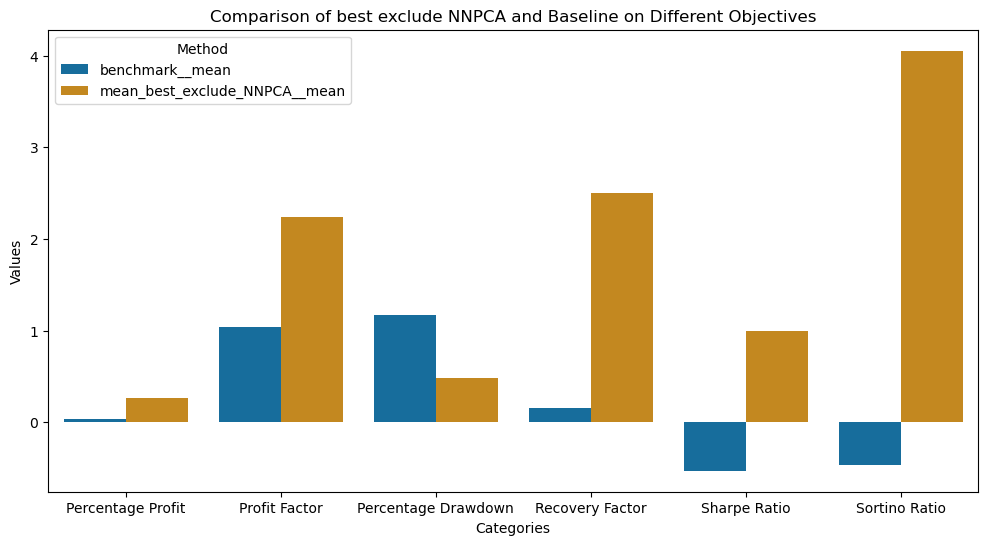

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame column names for the two methods
# Replace 'method1' and 'method2' with your actual column names
method1 = 'benchmark__mean'
method2 = 'mean_best_exclude_NNPCA__mean'

# Preparing the data for Seaborn
df_long = df.reset_index().melt(id_vars='index', value_vars=[method1, method2])
df_long.rename(columns={'index': 'Category', 'variable': 'Method', 'value': 'Value'}, inplace=True)

# Creating the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Value', hue='Method', data=df_long)

# Adding titles and labels
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Comparison of best exclude NNPCA and Baseline on Different Objectives')
plt.xticks(rotation=0)  
sns.set_palette("colorblind")

# Show plot
plt.show()


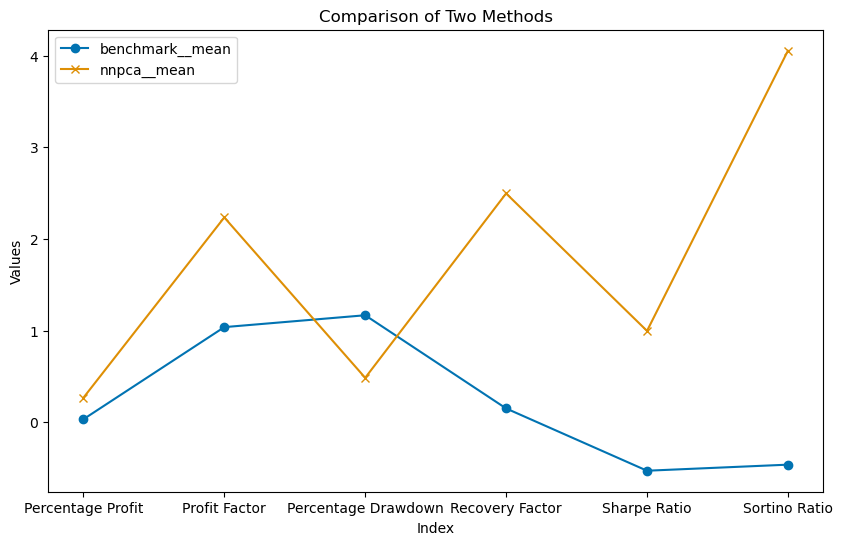

In [92]:
plt.figure(figsize=(10, 6))
method1 = 'benchmark__mean'
method2 = 'nnpca__mean'

plt.plot(df.index, df[method1], label=method1, marker='o') # Line plot for the first method
plt.plot(df.index, df[method2], label=method2, marker='x') # Line plot for the second method
# Adding titles and labels
plt.title('Comparison of Two Methods')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show plot
plt.show()

In [20]:
path = 'D:/github/ST5188_StatisticalProject/results/full_dataset_results/'
files = os.listdir(path)

In [21]:
files
files = [files[i] for i in [5,6,7,8,9]]
print(files)

['NNPCA+ensemble+filter.txt', 'NNPCA+OLS+filter.txt', 'pca_filter_ensemble.txt', 'pca_filter_statistics.txt', 'proposed_model_and_statistics.txt']


In [35]:
# result pnl
def read_file2(file_path):
    vals = [] 
    dates = []
    d = []
    count = 0
    ans = []
    with open(file_path, 'r') as file:
        next(file) 
        for line in file:
            if line.strip() and line.strip()[0] == "2":
                date, value = line.strip().split(maxsplit=1)
                #data.append([date, float(value)])
                vals.append(float(value))
                dates.append(date)
            else:
                if len(vals)>0:
                    series = pd.Series(vals,index=dates)
                    #t = Strategy_Evaluation(series, verbose=True, out=False, n_round=3)
                    ans.append(series)
                
                    vals = [] 
                    dates = []
    if len(vals)>0:
        series = pd.Series(vals,index=dates)
        ans.append(series)
    return ans

In [52]:
path = 'D:/github/ST5188_StatisticalProject/results/full_dataset_results/'
files = os.listdir(path)
files = [files[i] for i in [5,6,7,8,9]]

{'NNPCA+ensemble+filter.txt': 'NNPCA + ensemble', 'NNPCA+OLS+filter.txt': 'NNPCA + OLS', 'pca_filter_ensemble.txt': 'PCA+ ensemble', 'pca_filter_statistics.txt': 'PCA + OLS', 'proposed_model_and_statistics.txt': 'baseline'}


C:\Users\xul14\AppData\Local\Temp\ipykernel_22260\3761405032.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


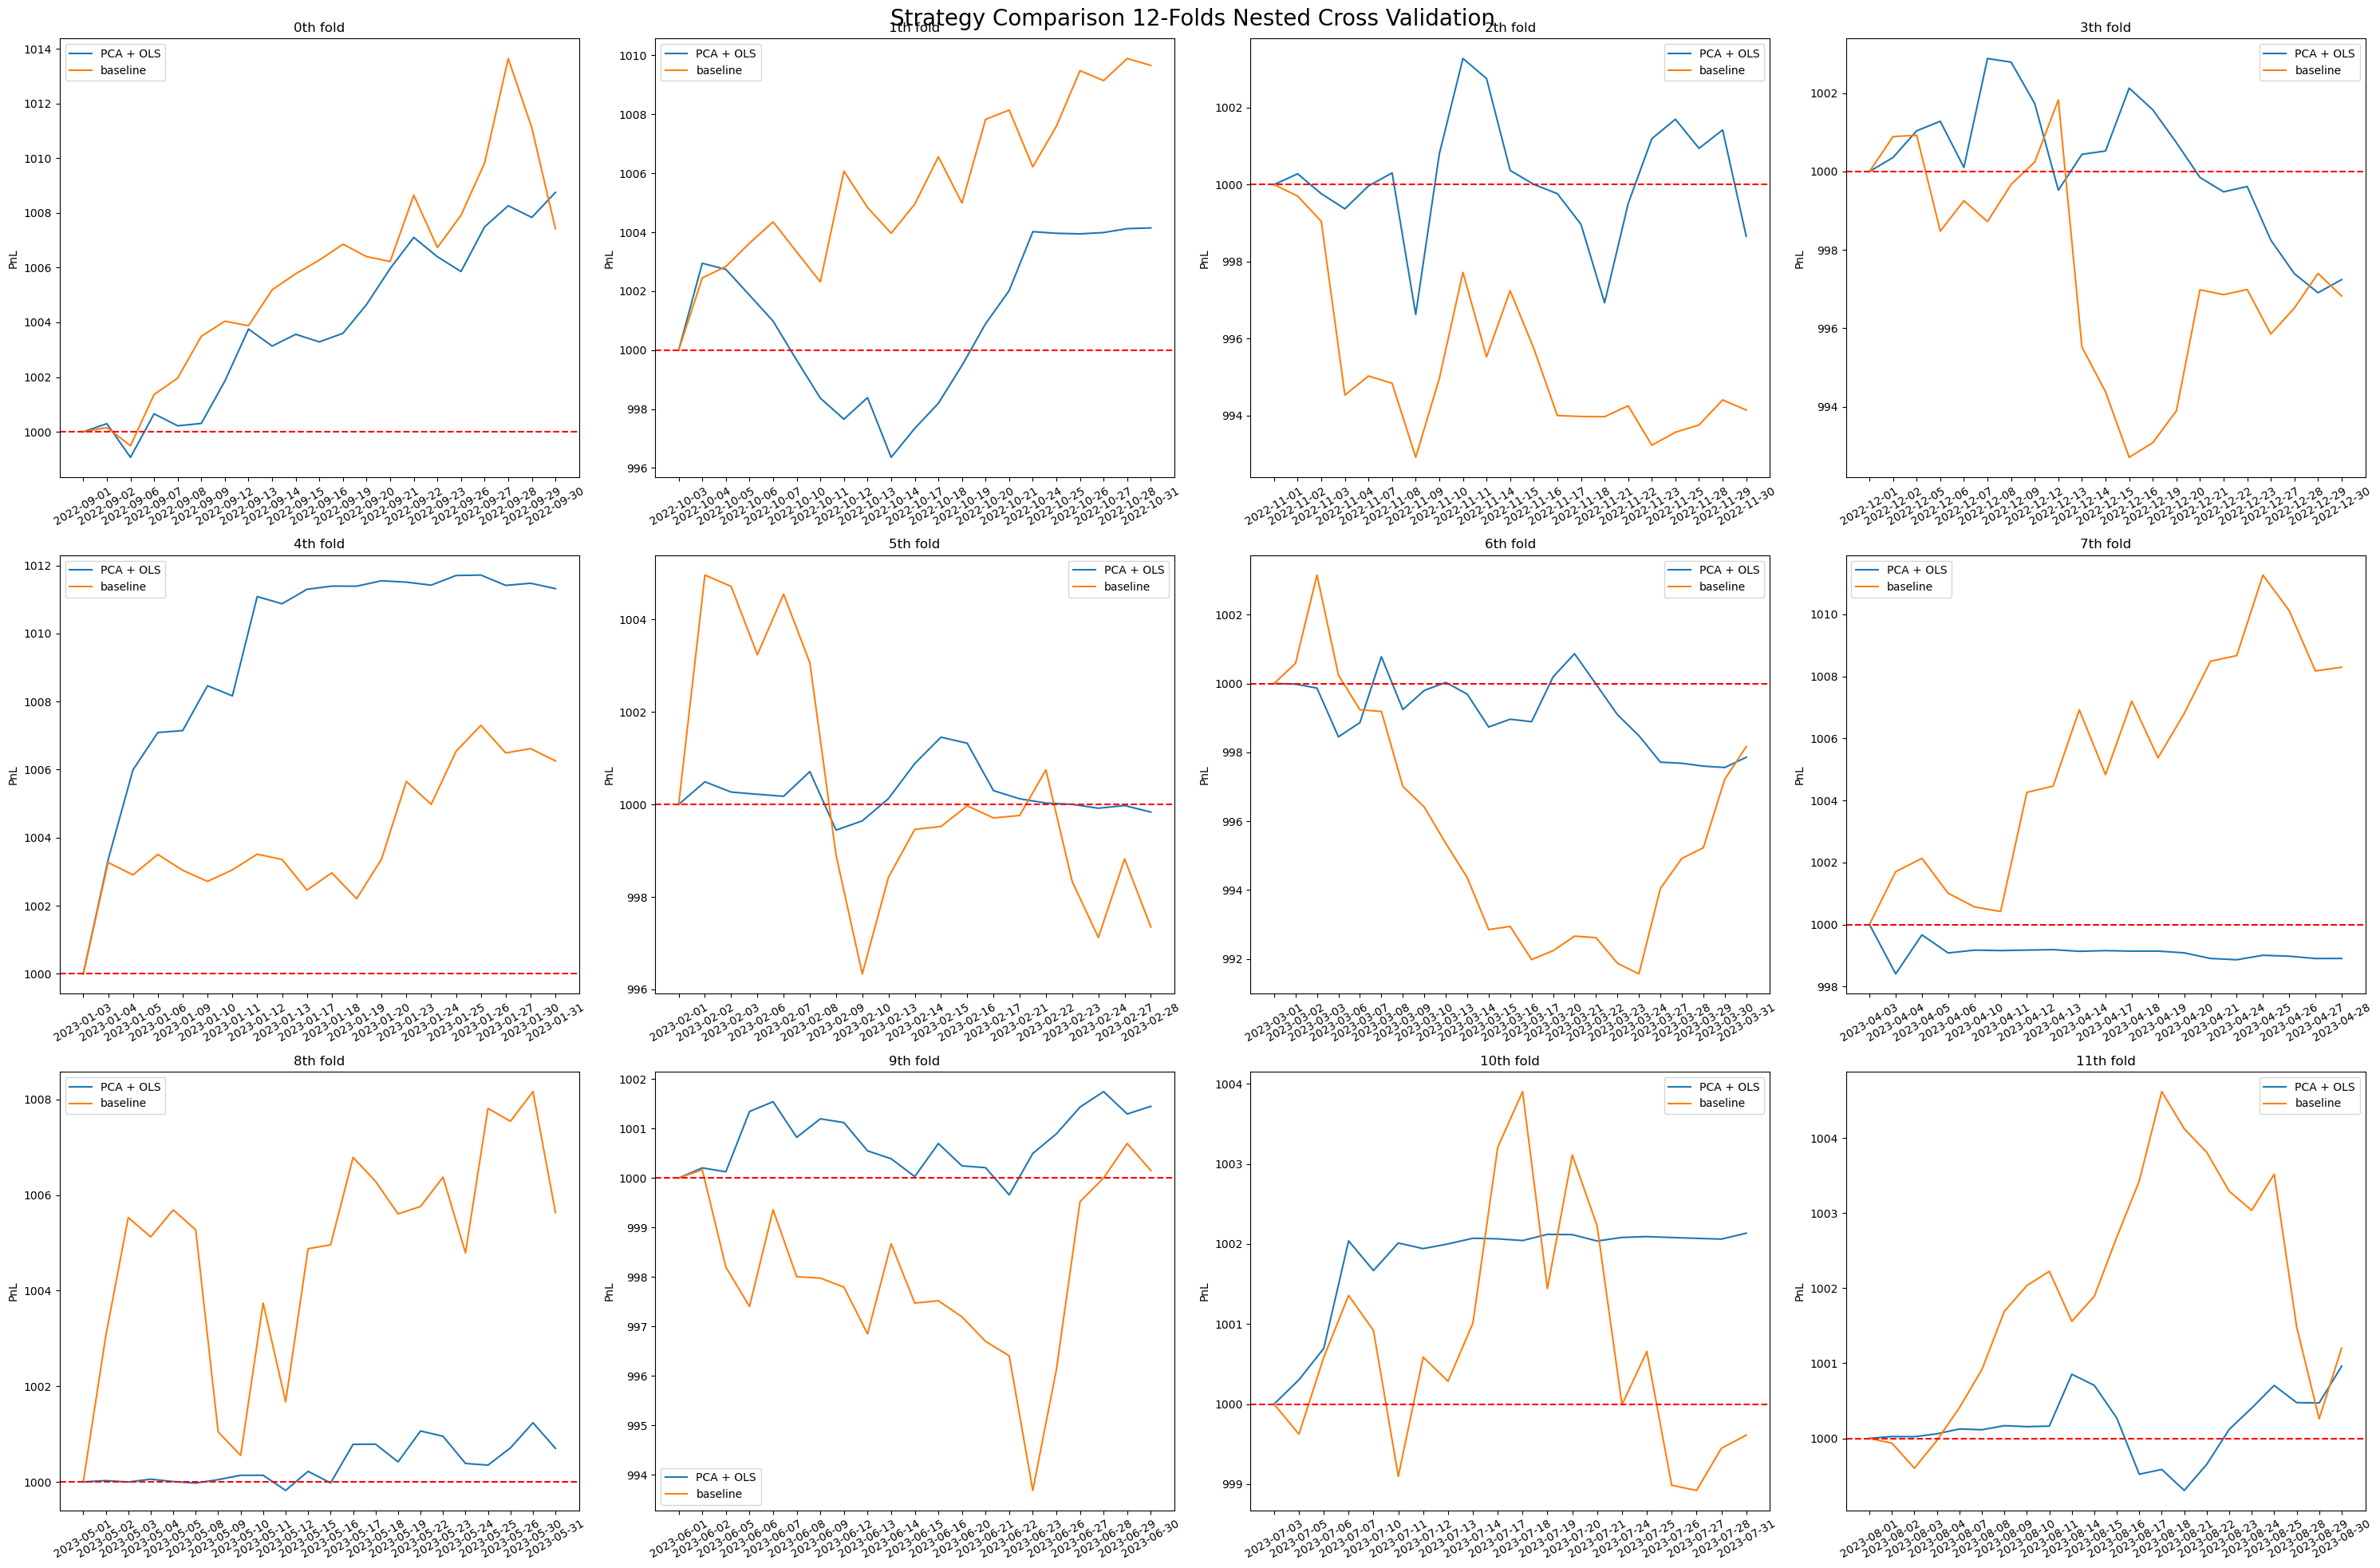

In [54]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
names = ["NNPCA + ensemble","NNPCA + OLS","PCA+ ensemble","PCA + OLS","baseline"]
d2 = dict(zip(files,names))
print(d2)
fig, axes = plt.subplots(3, 4, figsize=(30, 20))
fig.suptitle("Strategy Comparison 12-Folds Nested Cross Validation",fontsize=20)
d = {}
for i in range(len(files)):
    try:
        d[files[i]] = read_file2(f'{path}'+files[i])
    except:
        pass
    
for i, ax in enumerate(axes.ravel()):
    for j in d2:
        if d2[j] in ['PCA + OLS','baseline']:
            try:
                ax.plot( d[j][i], label=d2[j])
            except:pass
    ax.set_title(f"{i}th fold")
    ax.axhline(y=1000, color='r', linestyle='--')
    ax.set_ylabel("PnL")

    ax.legend()
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
plt.tight_layout()
plt.legend()
plt.show()

In [230]:
df

,NNPCA+ensemble+filter__mean,NNPCA+ensemble+filter__std,NNPCA+ensemble+filter__wse,NNPCA+OLS+filter__mean,NNPCA+OLS+filter__std,NNPCA+OLS+filter__wse,pca_filter_ensemble__mean,pca_filter_ensemble__std,pca_filter_ensemble__wse,pca_filter_statistics__mean,pca_filter_statistics__std,pca_filter_statistics__wse,proposed_model_and_statistics__mean,proposed_model_and_statistics__std,proposed_model_and_statistics__wse
Percentage Profit,-0.054094,0.404518,-0.608551,0.091878,0.748871,-1.083985,-0.074244,0.207272,-0.536432,0.182966,0.431648,-0.275714,0.205991,0.516598,-0.585643
Profit Factor,0.784100,0.678358,0.235545,1.254520,0.967862,0.277955,0.944582,0.455913,0.131544,2.390330,3.034052,0.585535,1.320670,0.590383,0.591403
Percentage Drawdown,0.241719,0.262296,0.000000,0.491637,0.342998,0.000000,0.221510,0.151460,0.025008,0.262534,0.233992,0.037038,0.581698,0.299638,0.130284
Recovery Factor,-0.051109,1.352077,-0.937860,0.631998,1.775852,-0.955579,0.029724,0.809429,-0.975598,3.504141,8.224207,-0.687906,1.077060,1.926797,-0.826528
Sharpe Ratio,-2.290247,4.377942,-7.410558,-0.188534,4.522928,-5.722263,-0.946499,3.184077,-8.422499,1.974737,3.611704,-1.887237,1.241322,2.676382,-2.709334
Sortino Ratio,-2.536587,5.604802,-10.191077,0.134393,6.951408,-8.006700,-0.868173,4.385431,-10.369065,6.736969,13.973853,-3.867531,2.901324,5.792290,-3.307877


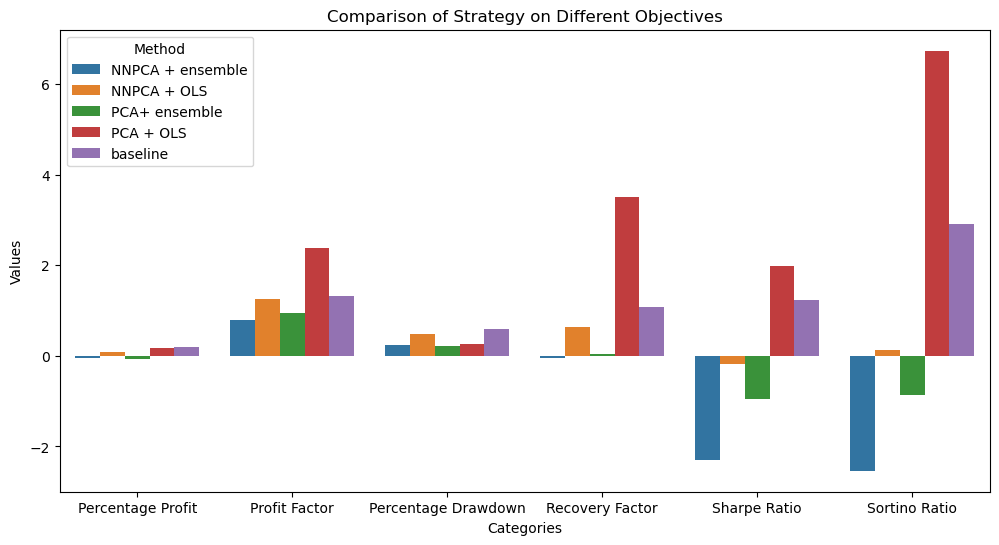

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame column names for the two methods
# Replace 'method1' and 'method2' with your actual column names

# Preparing the data for Seaborn
df_long = df.reset_index().melt(id_vars='index', value_vars=df.columns)
df_long.rename(columns={'index': 'Category', 'variable': 'Method', 'value': 'Value'}, inplace=True)

# Creating the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Value', hue='Method', data=df_long)

# Adding titles and labels
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Comparison of Strategies on Different Objectives')
plt.xticks(rotation=0)  
sns.set_palette([ "#1f77b4",  # Sky Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b" ])

# Show plot
plt.show()
